In [203]:
# Packages
using Knet, AutoGrad, LinearAlgebra, Base.Iterators, Statistics, Random, StatsBase, IterTools, Plots

In [118]:
# Constants
ENV["COLUMNS"] = 64
ARRAY=Array{Float64} # KnetArray{Float32}
UPDATE=true # keep this true (false only useful for checking gradients)
BSIZE=1     # keep batchsize=1 until larger ones supported
XSIZE=28*28
YSIZE=10
HSIZE=[64]
ALPHA=100.0
GAMMA1=0.0001
GAMMA2=0.01
LAMBDA=0.995
ETA=0.1
MU0=0.0001

0.0001

In [119]:
# Load minibatched MNIST data:
include(Knet.dir("data","mnist.jl"))
dtrn, dtst = mnistdata(xtype=ARRAY, batchsize=BSIZE)
xtrn, ytrn, xtst, ytst = mnist()
xtrn = ARRAY(reshape(xtrn,(XSIZE,:)))
xtst = ARRAY(reshape(xtst,(XSIZE,:)));

In [120]:
# Model definition and initialization
struct MLP; W; b; μ; B; g1; ∇g1; g2; ∇g2;
    function MLP(dims...;α=ALPHA)
        h,o = dims[end-1:end]
        W = initw.(dims[1:end-1],dims[2:end])
        b = initb.(dims[2:end])
        μ = initμ(h,o)
        B = initB(h,o;α=α)
        g1 = initg1(B)
        ∇g1 = init∇g1(h)
        g2 = initg2(μ)
        ∇g2 = init∇g2(h)
        new(W, b, μ, B, g1, ∇g1, g2, ∇g2)
    end
end

initw(i,o)=Param(ARRAY(xavier(o,i)))
initb(o)=Param(ARRAY(zeros(o,1)))
initμ(h,o)=ARRAY(MU0*randn(h,o))
initB(h,o;α=ALPHA)=(B = zeros(h,h,o); for i in 1:o, j in 1:h; B[j,j,i] = α; end; ARRAY(B))
initg1(B)=[ -sum(logdet.(B[:,:,i] for i in 1:size(B,3))) ]
init∇g1(h)=ARRAY(zeros(h,1))
initg2(μ)=((d,n)=(0,size(μ,2));for i=1:n-1,j=i+1:n;d-=log(norm(μ[:,i]-μ[:,j])^2);end;[d])
init∇g2(h)=ARRAY(zeros(h,1))

Base.show(io::IO, m::MLP)=print(IOContext(io,:compact=>true), "MLP", (size(m.W[1],2),length.(m.b)...))

In [121]:
# Featurevec, predict and loss functions
function featurevector(m::MLP,x)
    L,y = length(m.W),mat(x)
    for l in 1:L-1
        y = relu.(m.b[l] .+ m.W[l] * y)
    end
    return y
end

function (m::MLP)(x) # predict
    m.b[end] .+ m.W[end] * featurevector(m,x)
end

function (m::MLP)(x,labels;γ1=GAMMA1,γ2=GAMMA2) # loss
    @assert length(labels)==1 "Batchsize > 1 not implemented yet."
    yfeat = featurevector(m,x)
    ypred = m.b[end] .+ m.W[end] * yfeat
    J = nll(ypred,labels)
    g1 = sumlogdet(yfeat,labels,m)
    g2 = meandist(yfeat,labels,m)
    return J + γ1 * g1 + γ2 * g2
end

In [122]:
# computes and returns g1 = ∑ logdet(Ci) = -Σ logdet(Bi)
# computes m.∇g1 if training()
# updates m.g1 and m.B if update=TRUE
function sumlogdet(y,labels,m; λ=LAMBDA, η=ETA, update=UPDATE)
    β = labels[1]   # β(n) class label for the nth sample
    μ = m.μ[:,β:β]  # μ[β(n)](n-1) exponentially weighted mean of class β(n) before the nth sample
    B = m.B[:,:,β]  # B[β(n)](n-1) exponentially weighted inverse covariance matrix of class β(n) before the nth sample
    
    y0 = y - μ      # ybar[L-1](n) the centralized feature vector
    z = B * y0      # unscaled gradient
    κ = (1-λ)*λ
    ξ = 1 / ((1/(1-λ)) + (y0' * B * y0)[1])  # gradient scaling
    A = (1/λ)*(B - z*z'*ξ)  
    B2 = A-(1-λ)*η*A*A/(1+(1-λ)*η*tr(A))  # updated inverse covariance matrix  
    g1 = m.g1[1] + logdet(B) - logdet(B2) # updated -sumlogdet(B)

    if training()  # Store gradient if differentiating
        m.∇g1 .= 2 * κ * B2 * y0
    end
    
    if update      # Update state if specified
        m.g1[1] = g1
        m.B[:,:,β] .= B2
    end

    return g1
end

@primitive sumlogdet(y,l,m;o...),dy  dy*m.∇g1

In [123]:
# computes and returns g2 = -Σ log |μi-μj|^2
# computes m.∇g2 if training()
# updates m.g2 and m.μ if update=TRUE
function meandist(y,labels,m; λ=LAMBDA, update=UPDATE)
    M = size(m.μ,2) # number of classes
    β = labels[1]   # β(n) class label for the nth sample
    μ1 = m.μ[:,β:β] # μ[β(n)](n-1) exponentially weighted mean of class β(n) before the nth sample
    μ2 = λ * μ1 + (1-λ) * y   # updated mean
    g2 = 0
    if training(); m.∇g2 .= 0; end
    for k=1:M
        if (k!=β)
            olddist = norm(m.μ[:,k:k]-μ1)^2
            newdist = norm(m.μ[:,k:k]-μ2)^2
            g2 = g2 + log(olddist) - log(newdist)
            if training()
                m.∇g2 .+= (2 * (1-λ) / newdist) * (m.μ[:,k:k]-μ2)
            end
        end
    end    
    if update
        m.g2[1] = g2
        m.μ[:,β:β] .= μ2
    end
    return g2
end

@primitive meandist(y,l,m;o...),dy  dy*m.∇g2

In [140]:
# Experiment 1: check model functions
UPDATE=false
(x,labels) = first(dtrn)
m = MLP(XSIZE,HSIZE...,YSIZE)
@show x |> summary
@show labels
@show (y = featurevector(m,x)) |> summary
@show (scores = m(x)) |> summary
@show J=nll(scores,labels)
@show g1=sumlogdet(y,labels,m)
@show g2=meandist(y,labels,m)
@show J + GAMMA1 * g1 + GAMMA2 * g2
@show m(x,labels)
UPDATE=true;

x |> summary = "28×28×1×1 Array{Float64,4}"
labels = UInt8[0x05]
(y = featurevector(m, x)) |> summary = "64×1 Array{Float64,2}"
(scores = m(x)) |> summary = "10×1 Array{Float64,2}"
J = nll(scores, labels) = 2.4778561096154585
g1 = sumlogdet(y, labels, m) = -2945.9880482939625
g2 = meandist(y, labels, m) = -35.75083284918922
J + GAMMA1 * g1 + GAMMA2 * g2 = -30.557107658243087
m(x, labels) = -30.557107658243087


In [129]:
# Experiment 2: check gradients
using AutoGrad: @gcheck, gcheck
(x,labels) = first(dtrn)
m = MLP(XSIZE,HSIZE...,YSIZE)
y = featurevector(m,x)
py = Param(y)
UPDATE=false
@show @gcheck sumlogdet(py,labels,m)
@show @gcheck meandist(py,labels,m)
@show @gcheck nll(m(x),labels)
@show @gcheck m(x,labels)
UPDATE=true;

#= In[129]:8 =# @gcheck(sumlogdet(py, labels, m)) = true
#= In[129]:9 =# @gcheck(meandist(py, labels, m)) = true
#= In[129]:10 =# @gcheck(nll(m(x), labels)) = true
#= In[129]:11 =# @gcheck(m(x, labels)) = true


In [138]:
# Experiment 3: train one epoch with regularization
Random.seed!(1)
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA1,GAMMA2=0.01,0.1
progress!(adam(m,dtst))
(acc=accuracy(m,dtst),nll=nll(m(xtst),ytst),g1=initg1(m.B)[1],g2=initg2(m.μ)[1]) 

-5.96e+00  100.00%┣████████┫ 10000/10000 [00:28/00:28, 362.85i/s]


(acc = 0.919, nll = 0.27138646039786907, g1 = -595.6611794864707, g2 = -235.20288970750443)

In [131]:
# Experiment 4: train one epoch without regularization
Random.seed!(1)
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA1,GAMMA2 = 0,0
progress!(adam(m,dtst))
(acc=accuracy(m,dtst),nll=nll(m(xtst),ytst),g1=initg1(m.B)[1],g2=initg2(m.μ)[1]) 

2.56e-05  100.00%┣█████████┫ 10000/10000 [00:29/00:29, 347.50i/s]


(acc = 0.9198, nll = 0.2600133985319897, g1 = -647.7278184729371, g2 = -232.03334179923695)

In [171]:
# Experiment 5: run to convergence with 100 instances, no regularization
Random.seed!(1)
d100 = take(dtrn,100)
countmap([Int(y[1]) for (x,y) in d100]) |> println
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA1,GAMMA2 = 0,0
a = collect(progress((adam!(m,d100);accuracy(m(xtst),ytst)) for i in 1:100))
findmax(a)

Dict(7=>10,4=>11,9=>11,10=>13,2=>6,3=>11,5=>5,8=>8,6=>11,1=>14)
6.89e-01  100.00%┣██████████████▉┫ 100/100 [00:32/00:32, 3.09i/s]


(0.689, 21)

In [180]:
@doc goldensection

```
goldensection(f,n;kwargs) => (fmin,xmin)
```

Find the minimum of `f` using concurrent golden section search in `n` dimensions. See `Knet.goldensection_demo()` for an example.

`f` is a function from a `Vector{Float64}` of length `n` to a `Number`.  It can return `NaN` for out of range inputs.  Goldensection will always start with a zero vector as the initial input to `f`, and the initial step size will be 1 in each dimension.  The user should define `f` to scale and shift this input range into a vector meaningful for their application. For positive inputs like learning rate or hidden size, you can use a transformation such as `x0*exp(x)` where `x` is a value `goldensection` passes to `f` and `x0` is your initial guess for this value. This will effectively start the search at `x0`, then move with multiplicative steps.

I designed this algorithm combining ideas from [Golden Section Search](http://apps.nrbook.com/empanel/index.html?pg=492) and [Hill Climbing Search](https://en.wikipedia.org/wiki/Hill_climbing). It essentially runs golden section search concurrently in each dimension, picking the next step based on estimated gain.

# Keyword arguments

  * `dxmin=0.1`: smallest step size.
  * `accel=φ`: acceleration rate. Golden ratio `φ=1.618...` is best.
  * `verbose=false`: use `true` to print individual steps.
  * `history=[]`: cache of `[(x,f(x)),...]` function evaluations.


In [181]:
# Experiment 6: find best γ1,γ2 for 100 instances
function evalgammas(gammas)
    global GAMMA1,GAMMA2
    GAMMA1 = exp(gammas[1]-5)
    GAMMA2 = exp(gammas[2]-5)
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,d100); accuracy(m(xtst),ytst)) for i in 1:100 ]
    println((GAMMA1,GAMMA2,findmax(a)...))
    -maximum(a)
end

# best = (0.01831563888873418, 0.03398058281256863, 0.6993, 53)
goldensection(evalgammas,2)

(0.006737946999085467, 0.006737946999085467, 0.6938, 87)
(0.01831563888873418, 0.006737946999085467, 0.6952, 30)
(0.01831563888873418, 0.01831563888873418, 0.6974, 61)
(0.01831563888873418, 0.09236880077985307, 0.6941, 43)
(0.09236880077985307, 0.01831563888873418, 0.6953, 27)
(0.01831563888873418, 0.03398058281256863, 0.6993, 53)
(0.006737946999085467, 0.03398058281256863, 0.6936, 26)
(0.03398058281256863, 0.03398058281256863, 0.6974, 40)
(0.012500757815767668, 0.03398058281256863, 0.6975, 45)
(0.01831563888873418, 0.049787068367863944, 0.6977, 22)
(0.02319236794081144, 0.03398058281256863, 0.6955, 45)
(0.015829214397789157, 0.03398058281256863, 0.6984, 50)
(0.01831563888873418, 0.026835383330071433, 0.6976, 46)
(0.01831563888873418, 0.03931819156550566, 0.6957, 55)


(-0.6993, [1.0, 1.61803])

In [188]:
# Experiment 6a: find best γ1,γ2 for 100 instances starting from small gamma
## Note: 100 iters do not seem enough for convergence with small gamma.
function evalgammas(gammas)
    global GAMMA1,GAMMA2
    GAMMA1 = exp(gammas[1]-10)
    GAMMA2 = exp(gammas[2]-10)
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,d100); accuracy(m(xtst),ytst)) for i in 1:100 ]
    println((GAMMA1,GAMMA2,findmax(a)...))
    -maximum(a)
end

# best = (0.00012340980408667956, 4.539992976248485e-5, 0.6939, 98)
goldensection(evalgammas,2)

(4.539992976248485e-5, 4.539992976248485e-5, 0.692, 95)
(0.00012340980408667956, 4.539992976248485e-5, 0.6939, 98)
(0.00012340980408667956, 0.00012340980408667956, 0.693, 94)
(0.0006223760840237344, 4.539992976248485e-5, 0.6899, 97)
(0.00022895936598912205, 4.539992976248485e-5, 0.6882, 94)
(8.422944361104595e-5, 4.539992976248485e-5, 0.6928, 87)
(0.00015626894596847642, 4.539992976248485e-5, 0.6879, 11)
(0.00010665640764946391, 4.539992976248485e-5, 0.693, 93)
(0.00012340980408667956, 2.4470702097434435e-5, 0.6885, 100)
(0.00012340980408667956, 6.651826484109067e-5, 0.6927, 98)
(0.00012340980408667956, 3.58535498068023e-5, 0.6879, 21)
(0.00012340980408667956, 5.253126896933724e-5, 0.6915, 99)


(-0.6939, [1.0, 0.0])

In [189]:
# Experiment 6b: find best γ1,γ2 for 100 instances starting from large gamma
function evalgammas(gammas)
    global GAMMA1,GAMMA2
    GAMMA1 = exp(gammas[1])
    GAMMA2 = exp(gammas[2])
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,d100); accuracy(m(xtst),ytst)) for i in 1:100 ]
    println((GAMMA1,GAMMA2,findmax(a)...))
    -maximum(a)
end

# best = (1.0, 1.465162285252178, 0.6904, 94)
goldensection(evalgammas,2)

(1.0, 1.0, 0.6901, 41)
(2.718281828459045, 1.0, 0.6563, 36)
(1.0, 2.718281828459045, 0.6751, 72)
(0.5390030827240446, 1.0, 0.6897, 83)
(1.0, 0.5390030827240446, 0.6786, 54)
(1.0, 1.465162285252178, 0.6904, 94)
(1.465162285252178, 1.465162285252178, 0.6854, 62)
(0.78972698844193, 1.465162285252178, 0.6859, 75)
(1.1570781991108985, 1.465162285252178, 0.6862, 67)
(1.0, 1.8552769586143045, 0.6814, 77)
(1.0, 1.2662603844563072, 0.6893, 88)


(-0.6904, [0.0, 0.381966])

In [183]:
# Experiment 7: run to convergence with 1000 instances, no regularization
Random.seed!(1)
d1000 = take(dtrn,1000)
countmap([Int(y[1]) for (x,y) in d1000]) |> println
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA1,GAMMA2,UPDATE = 0,0,false
a = collect(progress((adam!(m,d1000);accuracy(m(xtst),ytst)) for i in 1:100))
UPDATE=true
findmax(a)

Dict(7=>117,4=>105,9=>100,10=>97,2=>99,3=>93,5=>92,8=>87,6=>94,1=>116)
8.85e-01  100.00%┣██████████████▉┫ 100/100 [05:16/05:16, 3.16s/i]


(0.8885, 13)

In [187]:
# Experiment 8: find best γ1,γ2 for 1000 instances
function evalgammas(gammas)
    global GAMMA1,GAMMA2
    GAMMA1 = exp(gammas[1]-4)
    GAMMA2 = exp(gammas[2]-4)
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,d1000); accuracy(m(xtst),ytst)) for i in 1:30 ]
    println((GAMMA1,GAMMA2,findmax(a)...))
    -maximum(a)
end

# best = (0.049787068367863944, 0.01831563888873418, 0.8817, 17)
goldensection(evalgammas,2)

(0.01831563888873418, 0.01831563888873418, 0.8774, 23)
(0.049787068367863944, 0.01831563888873418, 0.8817, 17)
(0.049787068367863944, 0.049787068367863944, 0.8767, 16)
(0.2510844326764283, 0.01831563888873418, 0.8771, 9)
(0.049787068367863944, 0.009872185823088117, 0.8792, 14)
(0.09236880077985307, 0.01831563888873418, 0.8793, 15)
(0.049787068367863944, 0.026835383330071433, 0.8791, 18)
(0.049787068367863944, 0.01446435434098994, 0.8763, 19)
(0.049787068367863944, 0.021192626460942082, 0.876, 10)
(0.03398058281256863, 0.01831563888873418, 0.8787, 12)
(0.06304339233244385, 0.01831563888873418, 0.8748, 22)
(0.043028265856292554, 0.01831563888873418, 0.8784, 18)


(-0.8817, [1.0, 0.0])

In [190]:
# Experiment 8a: find best γ1,γ2 for 1000 instances starting from small gamma
function evalgammas(gammas)
    global GAMMA1,GAMMA2
    GAMMA1 = exp(gammas[1]-16)
    GAMMA2 = exp(gammas[2]-16)
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,d1000); accuracy(m(xtst),ytst)) for i in 1:30 ]
    println((GAMMA1,GAMMA2,findmax(a)...))
    -maximum(a)
end

# best = (3.873519899647185e-7, 7.680731059760373e-8, 0.889, 14)
goldensection(evalgammas,2)

(1.1253517471925912e-7, 1.1253517471925912e-7, 0.8883, 15)
(3.059023205018258e-7, 1.1253517471925912e-7, 0.8885, 14)
(3.059023205018258e-7, 3.059023205018258e-7, 0.8875, 14)
(3.059023205018258e-7, 6.065680608856974e-8, 0.888, 14)
(1.542716072978916e-6, 1.1253517471925912e-7, 0.8875, 14)
(3.059023205018258e-7, 1.648822937629228e-7, 0.8873, 16)
(3.059023205018258e-7, 8.88720646248269e-8, 0.8889, 14)
(3.059023205018258e-7, 7.680731059760373e-8, 0.889, 14)
(5.675335268136856e-7, 7.680731059760373e-8, 0.8874, 14)
(2.0878391669027646e-7, 7.680731059760373e-8, 0.8882, 15)
(3.873519899647185e-7, 7.680731059760373e-8, 0.889, 14)
(2.6437480261652313e-7, 7.680731059760373e-8, 0.8883, 15)


(-0.889, [1.0, -0.381966])

In [194]:
# Experiment 9: compute learning curve
# Hyperparameter optimization failed, using γ1=γ2=0.01 as default
# Compare with/without regularization for various dataset sizes
# 1. Regularization has a slight advantage for small sizes (may be more significant with hyperparam optimization)
# 2. The advantage reduces, disappears as dataset size gets bigger
# 3. We get a negative log problem at n=1024
results9 = Dict()
for p in 5:15, g in (0,0.01)
    data = take(dtrn,2^p)
    GAMMA1 = GAMMA2 = g
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,data); accuracy(m(xtst),ytst)) for i in 1:100 ]
    println((n=2^p,γ=g,acc=maximum(a)))
    results9[(n=2^p,γ=g)] = a
end

(n = 32, γ = 0, acc = 0.5578)
(n = 32, γ = 0.01, acc = 0.5632)
(n = 64, γ = 0, acc = 0.6832)
(n = 64, γ = 0.01, acc = 0.6837)
(n = 128, γ = 0, acc = 0.7236)
(n = 128, γ = 0.01, acc = 0.7237)
(n = 256, γ = 0, acc = 0.798)
(n = 256, γ = 0.01, acc = 0.7995)
(n = 512, γ = 0, acc = 0.8546)
(n = 512, γ = 0.01, acc = 0.8507)

Stacktrace:
 [1] throw_complex_domainerror(::Symbol, ::Float64) at ./math.jl:31
 [2] log(::Float64) at ./special/log.jl:285
 [3] logdet(::Array{Float64,2}) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/generic.jl:1336
 [4] #sumlogdet#529(::Float64, ::Float64, ::Bool, ::Function, ::Array{Float64,2}, ::Array{UInt8,1}, ::MLP) at ./In[122]:15
 [5] sumlogdet(::Array{Float64,2}, ::Array{UInt8,1}, ::MLP) at ./In[122]:5
 [6] #forw#1(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Function, ::AutoGrad.Result{Array{Float64,2}}, ::Vararg{Any,N} where N) at /home/ec2-user/.julia/dev/AutoGrad/src/core.

DomainError: DomainError with -1.0:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [195]:
#= Learning curve:
(n = 32, γ = 0, acc = 0.5578)
(n = 32, γ = 0.01, acc = 0.5632)
(n = 64, γ = 0, acc = 0.6832)
(n = 64, γ = 0.01, acc = 0.6837)
(n = 128, γ = 0, acc = 0.7236)
(n = 128, γ = 0.01, acc = 0.7237)
(n = 256, γ = 0, acc = 0.798)
(n = 256, γ = 0.01, acc = 0.7995)
(n = 512, γ = 0, acc = 0.8546)
(n = 512, γ = 0.01, acc = 0.8507)
=#

In [200]:
# Experiment 10: Compute training curve with no regularization
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA1, GAMMA2, UPDATE = 0, 0, false
m0 = MLP(XSIZE,HSIZE...,YSIZE)
r0 = collect(progress(accuracy(m0(xtst),ytst) for z in 
             takenth(adam(m0,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.55e-01  100.00%┣█████████████████┫ 60/60 [04:04/04:04, 4.07s/i]


60-element Array{Float64,1}:
 0.8507
 0.8802
 0.893 
 0.8963
 0.9023
 0.9029
 0.9087
 0.9214
 0.9135
 0.9283
 0.9229
 0.9178
 0.9351
 ⋮     
 0.9391
 0.9518
 0.9598
 0.9606
 0.9601
 0.9562
 0.9547
 0.9605
 0.9518
 0.956 
 0.9493
 0.9547

In [201]:
# Experiment 11: Compute training curve with regularization
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA1, GAMMA2, UPDATE = 0.01, 0.01, true
m1 = MLP(XSIZE,HSIZE...,YSIZE)
r1 = collect(progress(accuracy(m1(xtst),ytst) for z in 
             takenth(adam(m1,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.51e-01  100.00%┣█████████████████┫ 60/60 [04:02/04:02, 4.04s/i]


60-element Array{Float64,1}:
 0.8483
 0.8783
 0.8841
 0.8974
 0.8998
 0.9069
 0.9049
 0.9212
 0.9187
 0.9303
 0.9244
 0.924 
 0.9325
 ⋮     
 0.9514
 0.9562
 0.9597
 0.9642
 0.9552
 0.9568
 0.9531
 0.9542
 0.9563
 0.9563
 0.946 
 0.9506

In [207]:
# Experiment 12: Compute training curve with regularization after an initial period
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA1, GAMMA2, UPDATE = 0, 0, false
m2 = MLP(XSIZE,HSIZE...,YSIZE)
r2 = collect(progress(
        (a=accuracy(m2(xtst),ytst); if a>0.9; global GAMMA1,GAMMA2,UPDATE=0.01,0.01,true; end; a)
        for z in takenth(adam(m2,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.49e-01  100.00%┣█████████████████┫ 60/60 [04:25/04:25, 4.42s/i]


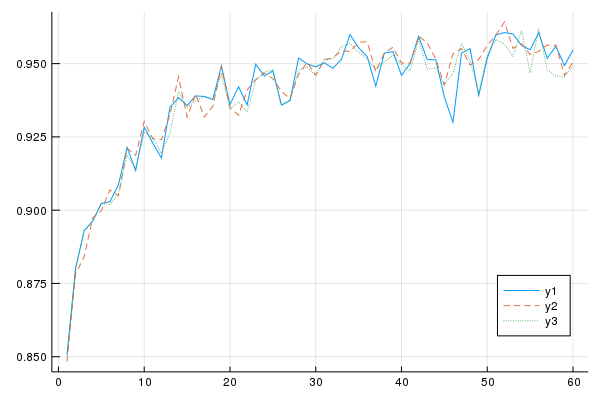

In [212]:
# Plot training curves
Plots.default(fmt=:png,ls=:auto,legend=:bottomright)
plot([r0 r1 r2])